# Getting started with database agents.

A few lines of code to get you started with agentic AI on Teradata Vantage.
We will create a simple "database agent" that can converse with a human user on one hand and query a Teradata Vantage database in the backend to find answers to the questions.

We will use pre-built Langchain components, a locally running LLM, and a Teradata Vantage database with minimal configuration and deployment headache.

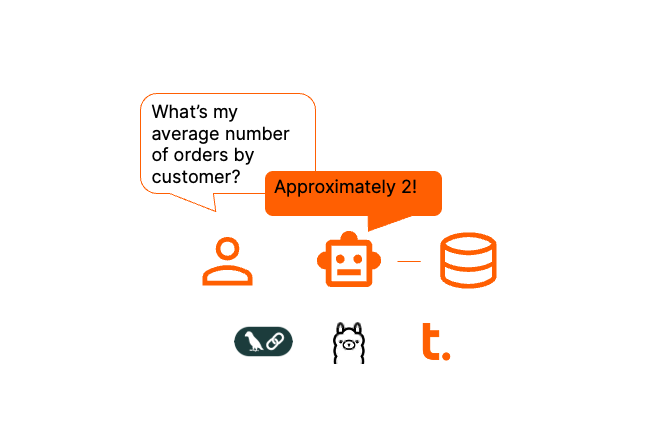

What you will learn:

✓ That Open Source models are capable enough to interact with the Teradata Vantage database and can run locally.

✓ That anyone can get started with agentic AI for data and analytics, using "out of the box" tools and models

✓ Simple tooling and prompting techniques can get us passed the first few roadblocks. No fine-tuning, no vector databases needed. 

Caution on the code: the intent here is to demonstrate how easy it is to get started and rapidly prototype ideas with agentic AI on Teradata Vantage. Do your testing, implement safeguards, talk to your platform team... 

## Connect to your favourite database

**Pre-requisite:** if you don't have a **Teradata Vantage** environment available right now, you can get one for free at [clearscape.teradata.com](clearscape.teradata.com), it takes 2 minutes.

LangChain provides convenient "out of the box" SQL tooling, let's use it to create a database connection, and see if we can list our objects our default schema contains:

In [ ]:
from langchain_community.utilities import SQLDatabase
import getpass

db_user="demo_user"
db_password=getpass.getpass("Enter your database password: ")
db_url="<your database URL here>"

db = SQLDatabase.from_uri(f"teradatasql://{db_user}:{db_password}@{db_url}?logmech=TD2", sample_rows_in_table_info = 3, view_support=True)
db.get_usable_table_names()[:7]+["..."]

['a',
 'customer',
 'customer_lifetime_value',
 'dim_customers',
 'dim_payment_method',
 'fct_orders',
 'key_customer',
 '...']

## Create an agent

Let's now connect a LLM service.

In this example we are using a [Ollama](https://ollama.com/) running locally on our laptop. You can use any other LLM provider (OpenAI, Anthropic, Nvidia NIM, etc...) [supported by LangChain](https://python.langchain.com/docs/integrations/llms/). 

In [5]:
from langchain_ollama import OllamaLLM
llm = OllamaLLM(model = "llama3.1")

Let's tune the agent prompt: this is optional, and can be improved. We find that the default prompt provided by LangChain can be tuned to improve the agent's SQL writing capabilities.

In [7]:
prefix="""
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct Teradata query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results by using the SAMPLE keyword at the end  of the query, for example: `SELECT ... SAMPLE 10;`
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Always use the format below, if you don't know, if you don't know, prefix your output with "Final Answer:"
Never return the query, always return the result of the query.
If the question does not seem related to the database, just return "Final Answer: I don't know" as the answer.

Ensure that your 
"""

And now create the agent using, once again LangChain's default utilities:

In [8]:
from langchain_community.agent_toolkits import create_sql_agent
from langchain.agents import AgentType

agent_executor = create_sql_agent(llm, db = db, agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, prefix=prefix, verbose = True)

This creates a "SQL" agent with basic database functionality: list objects, sample data and run queries. 
But it "works" out of the box  and can do a few things like:
- Tell me what's in my database
- Run simple queries
- Run more complex queries with nesting, joins and aggregations

Let's give it a try:

In [14]:
agent_executor.invoke("What is the average number of orders by customer?", handle_parsing_errors=True)



> Entering new SQL Agent Executor chain...
Action: sql_db_list_tables
Action Input: a, customer, customer_lifetime_value, dim_customers, dim_payment_method, fct_orders, key_customer, lim_customers, lim_market_competitors, lim_market_customers, lim_orders, lim_payments, order_payments, raw_customers, raw_market_competitors, raw_market_customers, raw_orders, raw_payments, sim_customers, sim_orders, sim_payments, stg_customers, stg_market_customers, stg_orders, stg_paymentsQuestion: What is the average number of orders by customer?

Thought: I should query the schema of the fct_orders and dim_customers tables to see what columns are available for querying.
Action: sql_db_schema
Action Input: fct_orders, dim_customers
CREATE TABLE dim_customers (
	customer_key INTEGER NOT NULL, 
	first_order DATE NOT NULL, 
	most_recent_order DATE NOT NULL, 
	number_of_orders INTEGER NOT NULL, 
	customer_lifetime_value INTEGER NOT NULL
)

/*
3 rows from dim_customers table:
customer_key	first_order	most_

{'input': 'What is the average number of orders by customer?',
 'output': '0.1596774'}

However we will rapidly reach limitations as the schema or query complexity grows.
This model doesn't have any information on how this model was actually designed and populated, it's just guessing its semantics and rules based on schema names and common data engineering patterns.

Let's try to be more creative...

## Simple tooling to better equip our database agents

As we have seen, Langchain offers a simple database adapter exposing a few tools and a "SQL Agent template".

This is useful but limited as it mainly guesses what a relevant query could look like based on table structures and data samples.
What if we could extend the knowledge available to this agent with information such as:
- Database documentation
- Object statistics
- Object usage patterns

**Tools** are a great, accessible and modular way to make agents more competent!

If we simplify, an agent has three components:
- A llm (and what runs it)
- The prompt that carries over the context and forms a working memory
- Tools that implement functions to interact with the external world: eg. triggrer actions, write or retrieve data, communicate with oter agents...


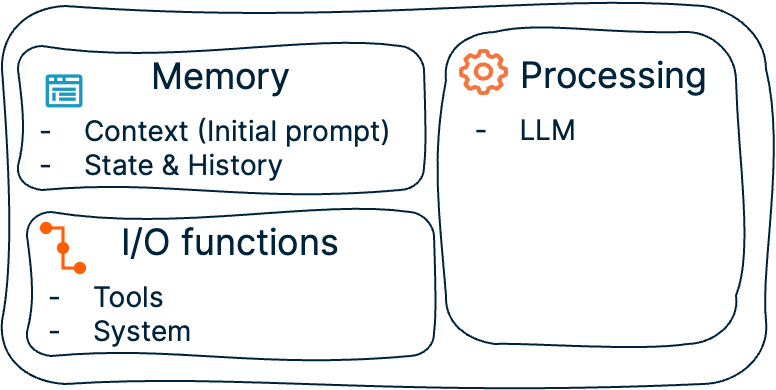

As mentioned LangChain did provide us with out of the obox tooling for SQL Agents, here are the tools available by default:

In [5]:
agent_executor.tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10794b5f0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10794b5f0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x10794b5f0>),
 QuerySQLCheckerTool(description='Use this tool to double check if your 

### Create your own SQL agent tool

Here is a simple example of how a new tool can be created for our SQL agent: let's give it a tool to gather table and column comments.

First we need to create a function that performs this logic:

In [17]:
from typing import Any, Dict, Iterable, List, Literal, Optional, Sequence, Union
def get_table_definition(db, table_names: Optional[List[str]] = None) -> str:
    """Get descriptions and commentary about specified tables.

    """
    all_table_names = db.get_usable_table_names()
    if table_names is not None:
        missing_tables = set(table_names).difference(all_table_names)
        if missing_tables:
            raise ValueError(f"table_names {missing_tables} not found in database")
        all_table_names = table_names

    meta_tables = [
        tbl
        for tbl in db._metadata.sorted_tables
        if tbl.name in set(all_table_names)
    ]

    tables = []
    for table in meta_tables:
        # add comment on table
        schema=f"'{table.schema}'" if table.schema else "database"
        table_comment = db._execute(f"select CommentString com from dbc.tablesV where databasename={schema} and tablename='{table.name}' and CommentString is not null")
        column_comment = db._execute(f"select columnname||': '||CommentString com from dbc.columnsV where databasename={schema} and tablename='{table.name}' and CommentString is not null")
        column_no_comment = db._execute(f"select columnname com from dbc.columnsV where databasename={schema} and tablename='{table.name}' and CommentString is null")
        if len(table_comment + column_comment)>0:
            table_info=f"Here is some useful information about the table **{table.name}**:\n"

            if len(table_comment)>0:
                table_info += "\nTable comment: "+str(table_comment[0]['com'])

            # add comments on columns
            if len(column_comment)>0:
                table_info += "\nColumn comments:\n"+'\n'.join(['- '+str(c['com']) for c in column_comment])
            
            table_info += "\nUn-documented columns:"+', '.join([str(c['com']) for c in column_no_comment])

        else:
            table_info=f"Unfortunately no information is available about the table **{table.name}**.\n"        
        tables.append(table_info)
    tables.sort()
    final_str = "\n\n".join(tables)
    return final_str

In [21]:
from IPython.display import Markdown, display
display(Markdown(get_table_definition(db)[:1000]+"..."))

Here is some useful information about the table **a**:

Table comment: This is a test table
Column comments:
- a: This is a test column
- b: This is another test column
Un-documented columns:c

Here is some useful information about the table **customer**:

Table comment: Customer base entity. We consider customers individuals that visited the shop and purchased at least once. Contains customer identifiers and dependant attributes. Curated and reusable.
Un-documented columns:customer_key, email

Here is some useful information about the table **dim_customers**:

Table comment: Customer dimension. Contains customer identifiers and dependant attributes. Semantic layer.
Column comments:
- customer_key: Customer identifier. Primary key.
Un-documented columns:customer_lifetime_value, number_of_orders, first_order, most_recent_order

Here is some useful information about the table **dim_payment_method**:

Table comment: Payment method dimension. Contains list of valid payment methods. Semanti...

Let's now make tools out of this function:

In [22]:
from langchain.tools import tool
@tool
def DatabaseObjectCommentTool(table_names: str = None) -> str:
    """
    Input to this tool is a comma-separated list of tables, output are all known documentation for those tables, hinting to what the content represents and how it can be used.
    Use this tool to gather documentation about what the database objects contain and how they can be used.
    Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3'
    """

    name: str = "sql_db_info"
    description: str = "Get the information for the specified SQL tables."

    return get_table_definition(db, [t.strip() for t in table_names.split(",")])

...and equip our agent with this new tool.

In [29]:
agent_executor_with_doc = create_sql_agent(llm, db = db, extra_tools=[DatabaseObjectCommentTool], agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, prefix=prefix, verbose = True)

Before (agent without the tool):

In [27]:
agent_executor.invoke("Explain to me what business this data is about and it can be used.", handle_parsing_errors=True)

{'input': 'Explain to me what business this data is about and it can be used.',
 'output': 'The business is likely an online retailer or e-commerce platform that processes payments from customers.'}

After (agent with the database documentation tool):

In [32]:
agent_executor_with_doc.invoke("Explain to me what business this data is about and it can be used.", handle_parsing_errors=True)



> Entering new SQL Agent Executor chain...
Question: Explain to me what business this data is about and it can be used.
Thought: I should look at the tables in the database to see what I can query.
Action: sql_db_list_tables
Action Input: a, customer, customer_lifetime_value, dim_customers, dim_payment_method, fct_orders, key_customer, lim_customers, lim_market_competitors, lim_market_customers, lim_orders, lim_payments, order_payments, raw_customers, raw_market_competitors, raw_market_customers, raw_orders, raw_payments, sim_customers, sim_orders, sim_payments, stg_customers, stg_market_customers, stg_orders, stg_paymentsThought: Now that I have the list of tables, I can try to understand what business this data is about by looking at the table names.
Action: DatabaseObjectCommentTool
Action Input: a, customer, fct_orders, lim_customers, lim_orders, stg_ordersHere is some useful information about the table **a**:

Table comment: This is a test table
Column comments:
- a: This is a t

{'input': 'Explain to me what business this data is about and it can be used.',
 'output': 'The business this data is about is a retail or e-commerce company that sells jaffles (a type of food). The data includes information about customers and their orders, with columns such as customer_key, order_date, status, credit_card_amount_usd, and amount. The data can be used to analyze customer behavior, sales trends, and revenue metrics.'}

## Simple role playing for better problem solving

Now we have agent that understands a little bit better what's in our database has smarter ways to navigate it.
But this is still going to be difficult to get good and consistent results for complex questions... 

In real life, you don't throw potentially complex business question at a single SQL developer, and expect them to come back shortly with a correct and business-grounded answer... You get multi-disciplinary teams to work on such problem by breaking it down. This may be as simple as having an analyst working alongside your developer.

That's what agentic workflows do with multiple role-playing agents do.

So let's go and implement a new agent "analyst" role, once again with minimal code change. We can achieve that by simply changing our prompt prefix.

In [14]:
prefix="""
You are a world class business consultant interacting with Teradata databases, and advising your audience on how to use this data to optimise their businesses, create additional value and ultimately disrupt their industry with groundbreaking industry use cases.
Given an input question, browse the database structures, commentary and data, reflect on the information gathered to provide a correct and creative answer grounded in the data as well as your best industry knowledge.
Always answer in business language as your audience is primarily business users with little database knowledge.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 10 results by using the SAMPLE keyword at the end  of the query, for example: `SELECT ... SAMPLE 10;`
You can order the results by a relevant column to return the most interesting examples in the database.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.

Always use the format below, if you don't know, if you don't know, prefix your output with "Final Answer:"
Never return the query, always return the result of the query.
If the question does not seem related to the database, just return "Final Answer: I don't know" as the answer.

"""
agent_executor_with_doc_prompt = create_sql_agent(llm, db = db, extra_tools=[DatabaseObjectCommentTool], agent_type=AgentType.ZERO_SHOT_REACT_DESCRIPTION, prefix=prefix)
agent_executor_with_doc_prompt.invoke("Explain to me what business this data is about and it can be used.", handle_parsing_errors=True)


{'input': 'Explain to me what business this data is about and it can be used.',
 'output': 'The data in this database appears to be related to an e-commerce business, specifically a coffee shop or bakery. The tables contain information on customers (customer base entity), orders (orders fact table), and payments (semantics layer). The database can be used for analyzing customer behavior, order history, payment methods, and revenue metrics. It can also be used to gain insights into customer demographics and preferences, as well as identify trends in purchasing habits.'}

## What to do next ?

We have seen how, with a very few lines of code you can:
- Create basic database agents able to interact with your Teradata platform, possibly with locally running small-ish LLMs.
- Equip your agents with modular tooling to better leverage the data platform.
- Create multiple agents with different roles for better problem-solving and more modularity in your agentic workflows.

We saw how LangChain provides an abstraction layer for your LLM, database services, tools and prompts so you can iterate rapidly over new ideas, experiment with different models and scale out when appropriate.

This gives us some of the key building blocks for more sophisticated agentic workflows for accelerating your organization's data and analytics productivity.